# Compare Temperature and Salinity from ACCESS-OM2 to WOA

This notebook shows examples of comparing ACCESS-OM2 Temperature and Salinity structure to the WOA13 climatology (that is used as initial conditions for most runs). We describe the location and setup of the WOA13 data interpolated onto the model grids, as well as plot SST and SSS anomalies along with equatorial slices of temperature and salinity anomalies.

In [1]:
from dask.distributed import Client
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 12
Total threads: 12,Total memory: 46.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38287,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35961,Total threads: 1
Dashboard: /proxy/37509/status,Memory: 3.83 GiB
Nanny: tcp://127.0.0.1:36603,


## WOA2018
WOA data is already a mean dataset so doesn't have time steps so it probably doesn't fit into those MIP naming conventions.

esmvaltool cmorised data is 1deg. Can run for quarter degree..?

 - https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:NCEI-WOA18
 - https://repository.library.noaa.gov/view/noaa/70445 #product documentation
 - https://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.nodc%3A0114815/html
 
 **so** - sea water salinity with olevel
 **sos** - sea surface salinity

In [2]:
from esmvalcore.dataset import Dataset

obs_woa = Dataset( #v OBS6 2018, OBS 2013v2
            short_name='thetao', dataset='WOA', #'thetao' depth
            mip="Omon", project='OBS6',
            type='*', tier=2)

facetsn = {'short_name':'sos'}
obs_so = obs_woa.copy(**facetsn) ##use as Dataset template
# ideg.. get 0.25 resolution?

list(obs_woa.files), list(obs_so.files), obs_woa.load().shape

(for file /g/data/ct11/access-nri/replicas/esmvaltool/obsdata-v2/Tier2/WOA/OBS6_WOA_clim_2018_Omon_thetao_200007-200007.nc)


([LocalFile('/g/data/ct11/access-nri/replicas/esmvaltool/obsdata-v2/Tier2/WOA/OBS6_WOA_clim_2018_Omon_thetao_200007-200007.nc')],
 [LocalFile('/g/data/ct11/access-nri/replicas/esmvaltool/obsdata-v2/Tier2/WOA/OBS6_WOA_clim_2018_Omon_sos_200007-200007.nc')],
 (1, 102, 180, 360))

## Comparing to ACCESS-OM2 simulations

Now lets plot some biases against the WOA13 data set. We will use the original ACCESS-OM2 IAF runs, so first define a dictionary with information on those runs

In [3]:
##use as model Dataset template
# model_datasets = {
model_OM2 = Dataset(short_name='tos', project='CMIP6',
    activity='OMIP', mip="Omon", exp="omip2",
    ensemble="r1i1p1f1", timerange="0306/0366",
    dataset="ACCESS-OM2", grid="gn")
# "ACCESS-OM2-025": ## WOA 1 deg - regrid?
#     Dataset(short_name='tos', project='CMIP6',
#     activity='OMIP', mip="Omon", exp="omip2",
#     ensemble="r1i1p1f1", timerange="0306/0366",
#     dataset="ACCESS-OM2-025", grid="gn"
# )}
model_OM2.files

[LocalFile('/g/data/fs38/publications/CMIP6/OMIP/CSIRO-COSIMA/ACCESS-OM2/omip2/r1i1p1f1/Omon/tos/gn/v20210616/tos_Omon_ACCESS-OM2_omip2_r1i1p1f1_gn_030601-036612.nc')]

In [ ]:
model_OM2.load()

## SST and SSS biases


In [4]:
## preprocessers
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_transect #latitude 0

# run climate_statistics, biases is model - WOA values for surface
def bias_woa(obs, model, shortname, grid): #for tos and sos
    facetsn = {'short_name':shortname}
    
    model_cube = model.copy(**facetsn).load()
    model_cube = climate_statistics(model_cube, period='full', operator='mean')
    model_cube = regrid(model_cube, target_grid=grid, scheme="linear")
    
    obs_var = obs.copy(**facetsn).load()[0] #woa has 1 time dimension
    obs_cube = regrid(obs_var, target_grid=grid, scheme="linear")
    anombias = model_cube - obs_cube
    return anombias, obs_var

# 025: model.copy(**facets) facets = {'dataset':'ACCESS-OM2-025'}, target grid = 0.25x0.25


In [5]:
import iris.plot as iplt
import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [6]:
%%time
# dict of cubes to plot
sst_cubes = {}
facetsn = {'short_name':'tos'}
cube, obs = bias_woa(obs_woa, model_OM2, 'tos',"1x1")
sst_cubes['ACCESS-OM2'] = cube
sst_cubes['WOA18'] = obs
facets = {'dataset':'ACCESS-OM2-025'}
cube, obs = bias_woa(obs_woa, model_OM2.copy(**facets), 'tos', "0.25x0.25")
sst_cubes['ACCESS-OM2-025'] = cube


CPU times: user 50.1 s, sys: 7.67 s, total: 57.8 s
Wall time: 1min 8s


In [7]:
## run bias for tos and sos for plot model bias, woa data 
# plot function for both

def plot_comparison(sst_cubes, ekeys, clev, labelbar, obs_levels):
    for i, ekey in enumerate(ekeys):
        ax = plt.subplot(1+len(ekeys)//2, 2, i+1, projection=ccrs.Robinson(central_longitude=-100))
        p0 = iplt.contourf(sst_cubes[ekey], axes=ax, cmap=cm.cm.balance, extend='both', levels=clev)
        ax.add_feature(cfeature.LAND, facecolor='gray')
        ax.coastlines()
        plt.title("({}) {}".format(chr(ord('a') + i), ekey)) #e['yearrange']
    
    i+=1
    
    ax1 = plt.subplot(1+len(ekeys)//2, 2, i+1, projection=ccrs.Robinson(central_longitude=-100))
    p1 = iplt.contourf(sst_cubes['WOA18'], axes=ax1, cmap=cm.cm.thermal, levels=obs_levels)
    ax1.add_feature(cfeature.LAND, facecolor='gray')
    ax1.coastlines()
    plt.title("({}) WOA18".format(chr(ord('a') + i)))
    
    ax5 = plt.axes([0.92, 0.52, 0.01, 0.33])
    cb = plt.colorbar(p0, cax=ax5, orientation='vertical')
    cb.ax.set_ylabel(' anomaly '.join(labelbar.split(' '))) #param ^split join ' anomaly '.join(labelbar.split(' '))
    
    ax6 = plt.axes([0.92,0.13,0.01,0.33])
    cb = plt.colorbar(p1, cax=ax6, orientation='vertical')
    cb.ax.set_ylabel(labelbar) 

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 80.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 20.8 s, sys: 6.21 s, total: 27 s
Wall time: 27.6 s


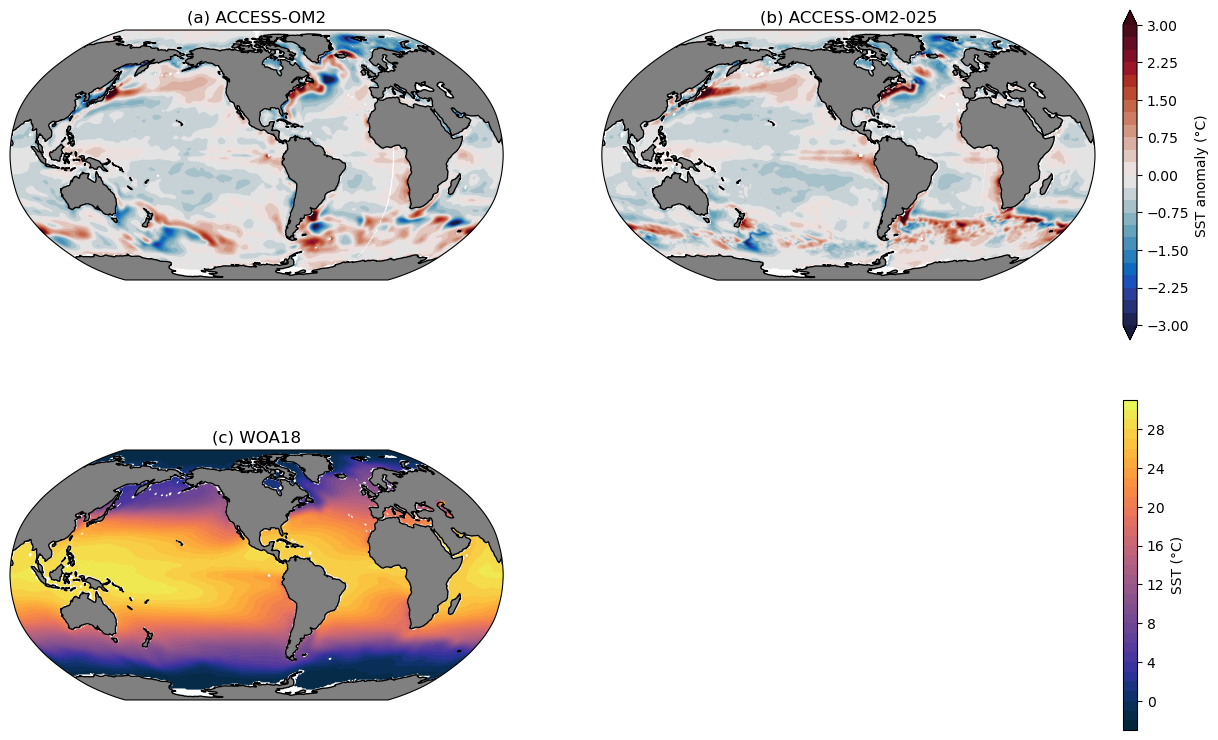

In [8]:
%%time

clev = np.arange(-3, 3.25, 0.25)
obs_levels = np.arange(-3., 32., 1.)
fig = plt.figure(figsize=(14, 10))

ekeys = ['ACCESS-OM2','ACCESS-OM2-025']
plot_comparison(sst_cubes, ekeys, clev, 'SST (°C)', obs_levels)

Then we do the same for sea surface salinity biases

In [9]:
%%time
# dict of cubes to plot
sss_cubes = {}

cube, obs = bias_woa(obs_woa, model_OM2, 'sos',"1x1")
sss_cubes['ACCESS-OM2'] = cube
sss_cubes['WOA18'] = obs
facets = {'dataset':'ACCESS-OM2-025'}
cube, obs = bias_woa(obs_woa, model_OM2.copy(**facets), 'sos', "0.25x0.25")
sss_cubes['ACCESS-OM2-025'] = cube


CPU times: user 47.9 s, sys: 5.53 s, total: 53.5 s
Wall time: 50.2 s


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 80.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


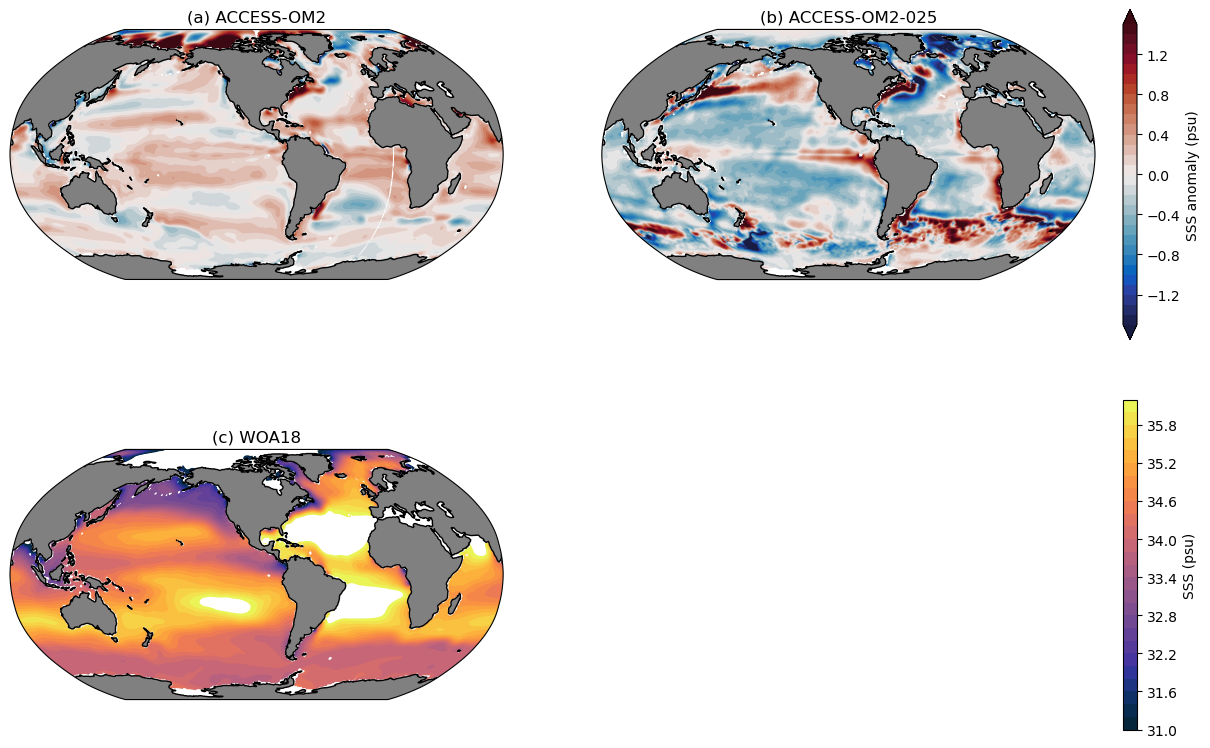

In [10]:
fig = plt.figure(figsize=(14, 10))
clev = np.arange(-1.5, 1.6, 0.1)
obs_levels=np.arange(31., 36.2, 0.2)
plot_comparison(sss_cubes, ekeys, clev, 'SSS (psu)', obs_levels)

## Equatorial Pacific Temperature and Salinity Longitude-depth biases

Our final example compares temperature and salinity biases in the tropical Pacific (note, this overlaps somewhat with the `Equatorial_thermal_and_zonal_velocity_structure.ipynb` documented example).

We follow the same procedure as before, first loading the data.

In [ ]:
test = model_OM2.copy(**facetsn).load()#[0].data.mean() #not degC

test.units = None #'kelvin' "K"
test = convert_units(test, 'degC')
test[0].data.mean()


281.469403431259

In [56]:
test = model_cube - obs_cube
# test.data
print(model_cube.units)
# obs_cube.data

degC


In [ ]:
from esmvalcore.preprocessor import extract_levels
# longitude-depth analysis - extract transect

def lon_depth_bias(obs, model, shortname, grid):
    facetsn = {'short_name':shortname} #thetao, so
    
    model_cube = model.copy(**facetsn).load()
    model_cube = regrid(model_cube, target_grid=grid, scheme="linear")
    model_cube = extract_transect(model_cube, latitude=0.)
    model_cube = climate_statistics(model_cube, period='full', operator='mean')
    depths = list(model_cube.coord('depth').points)
    print(model_cube.units, model_cube.data.mean())
    # model da
    obs_cube = obs.copy(**facetsn).load()[0] #woa has 1 time dimension
    obs_cube = regrid(obs_cube, target_grid=grid, scheme="linear")
    obs_cube = extract_transect(obs_cube, latitude=0.)
    obs_cube = extract_levels(obs_cube, depths, scheme='linear')
    
    # anombias = model_cube - obs_cube # do outside function
    return model_cube, obs_cube

def mod_units(cbfix):
    cbfix.units = "K"
    return convert_units(cbfix, 'degC')


In [ ]:
%%time
# dict of cubes to plot
sstdepth_cubes = {}

modcube, obs = lon_depth_bias(obs_woa, model_OM2, 'thetao',"1x1")
sstdepth_cubes['ACCESS-OM2'] = modcube - obs
sstdepth_cubes['WOA18'] = obs

facets = {'dataset':'ACCESS-OM2-025'}
mod2cube, obs = lon_depth_bias(obs_woa, model_OM2.copy(**facets), 'thetao', "0.25x0.25")
sstdepth_cubes['ACCESS-OM2-025'] = mod2cube - obs
mod2cube + obs


(for file /g/data/ct11/access-nri/replicas/esmvaltool/obsdata-v2/Tier2/WOA/OBS6_WOA_clim_2018_Omon_thetao_200007-200007.nc)
(for file /g/data/ct11/access-nri/replicas/esmvaltool/obsdata-v2/Tier2/WOA/OBS6_WOA_clim_2018_Omon_thetao_200007-200007.nc)


CPU times: user 55.7 s, sys: 8.2 s, total: 1min 3s
Wall time: 1min 14s


Then plotting equatorial plots of temperature biases

In [ ]:
# Define contour levels
clev = np.arange(-3.,3.25,0.25)

# Define a function to plot Equatorial Slices
def plot_eqtemp(ekeys, sst_cubes, clev):

    # Loop through models
    for i, ekey in enumerate(ekeys):
        ax1 = plt.subplot(int(np.ceil(len(ekeys)/2)), 2, i+1)
        
        # Plot bias as color #y axis decreaseing ..*-1
        pn = iplt.contourf(sst_cubes[ekey], axes=ax1, cmap='bwr', levels=clev)#, yincrease=False)
        
        # Plot WOA13 isotherms (and 20C bold)
        CS = iplt.contour(sst_cubes['WOA18'], axes=ax1, levels=np.arange(0, 32, 2), colors='k')
        ax1.clabel(CS, inline=False, fmt='%d', fontsize=15)
        iplt.contour(sst_cubes['WOA18'], axes=ax1, levels=[20.], colors='k', linewidths=3.)
        cube_add = sst_cubes[ekey] + sst_cubes['WOA18'] #other model, add before
        iplt.contour(cube_add, axes=ax1, levels=[20.], colors='k', linewidths=3., linestyles='--')
        
        ax1.invert_yaxis()
        # Add annotations
        plt.title("({}) {}".format(chr(ord('a') + i), ekey))
        ax1.set_ylim([300., 0.])
        ax1.set_xlim([-220., -80.])
        ax1.set_ylabel('Depth (m)')
        ax1.set_xlabel('Longitude ($^\circ$E)')
        
        if i == 0:
            ax1.text(-210., 275., 'WOA18 Isotherms', fontsize=15)

    ax5 = plt.axes([0.92, 0.2, 0.01, 0.5])
    cb = plt.colorbar(p0, cax=ax5, orientation='vertical')
    cb.ax.set_ylabel('Temperature anomaly (°C)')

Plot temperature comparison of IAF simulations.

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/iris/plot.py:574: UserWarning: The following kwargs were not used by contour: 'yincrease'
  result = draw_method(u, v, data, *args, **kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 80.87 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


ValueError: Cannot resolve cubes, as a suitable transpose of the RHS cube 'sea_water_potential_temperature' will not broadcast with the LHS cube 'unknown'.

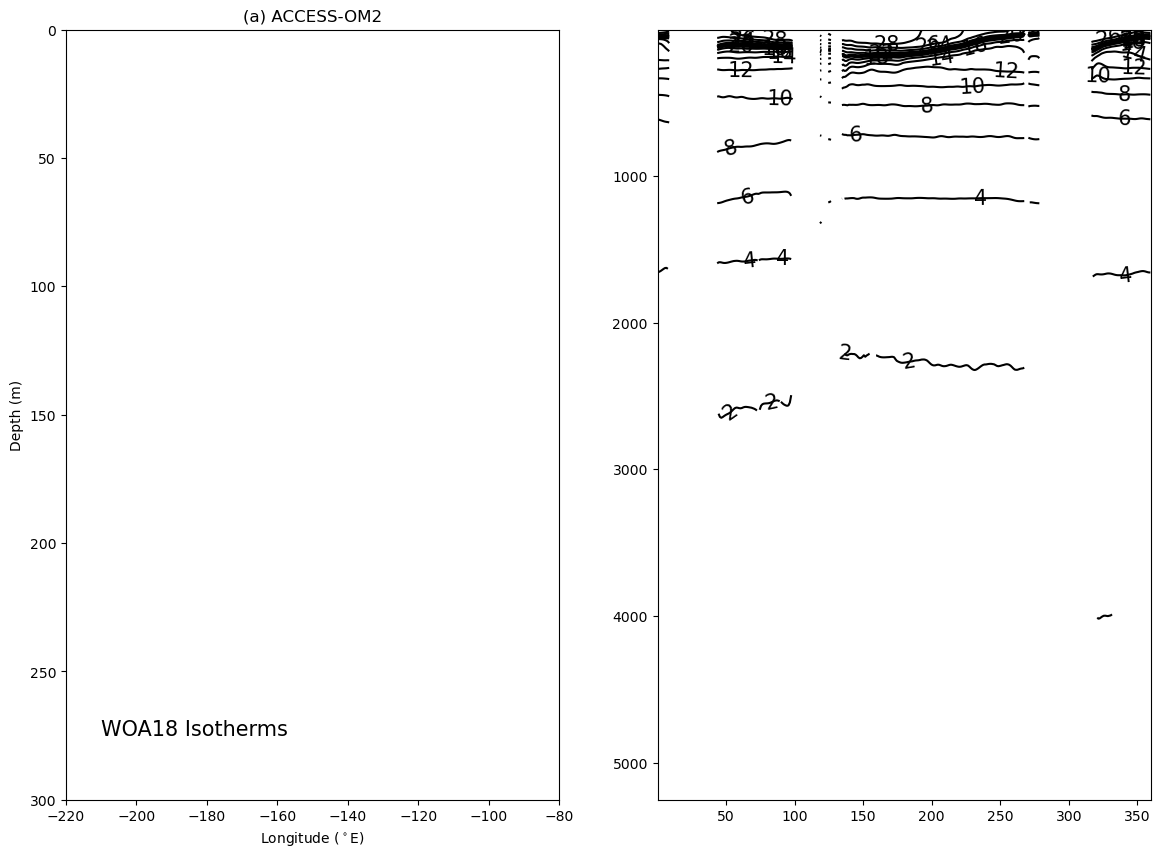

In [46]:
fig = plt.figure(figsize=(14, 10))
# Define contour levels
clev = np.arange(-3.,3.25,0.25)
# obs_levels=np.arange(31., 36.2, 0.2)
plot_eqtemp(ekeys,sstdepth_cubes, clev) #, 'SSS (psu)', obs_levels)

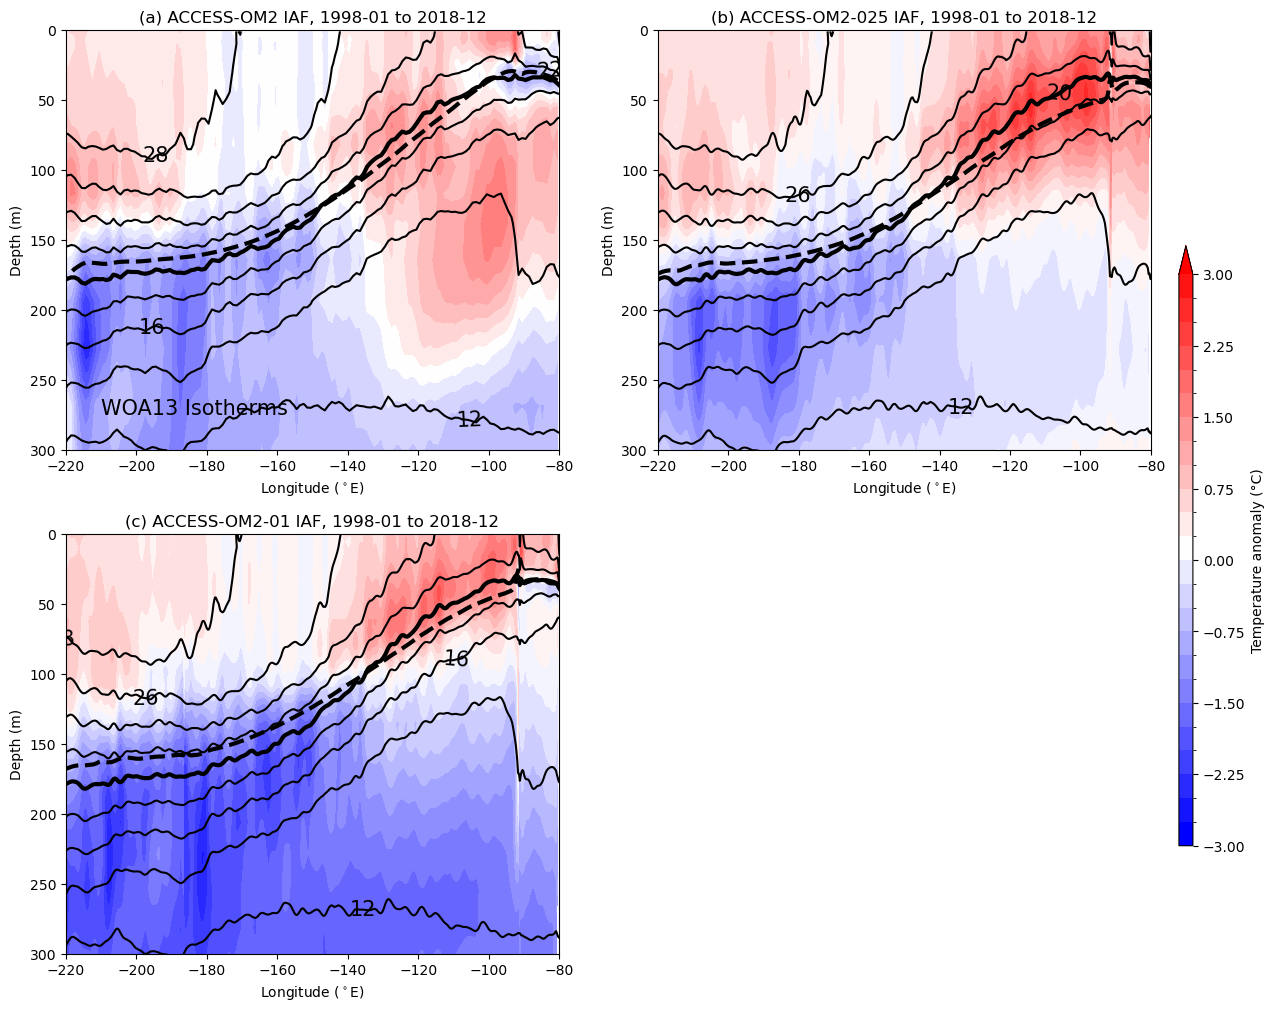

In [14]:
fig = plt.figure(figsize=(14, 12))
ekeys = ['1degIAF', '025degIAF', '01degIAF']
plot_eqtemp(ekeys)

And finally, repeat the same for salinity.

In [15]:
# Define a function to plot Equatorial Slices of salinity
def plot_eqsalt(ekeys):
    
    # Define contour levels
    clev = np.arange(-1., 1.1, 0.1)

    # Loop through models
    for i, ekey in enumerate(ekeys):
        e = exptdict[ekey]
        ax1 = plt.subplot(int(np.ceil(len(ekeys)/2)), 2, i+1)
        
        # Plot bias as color
        pn = e['eq_salt_anom'].plot.contourf(cmap='bwr', levels=clev, add_colorbar=False, yincrease=False)
        
        # Plot WOA13 salinity (and 20C bold)
        CS = e['eq_salt_WOA13'].plot.contour(levels=np.arange(30., 36.1, 0.1), colors='k')
        ax1.clabel(CS, inline=False, fmt='%3.2f', fontsize=15)
        
        # Add annotations
        plt.title("({}) {}, {}".format(chr(ord('a') + i), e['model'], e['yearrange']))
        ax1.set_ylim([300., 0.])
        ax1.set_xlim([-220., -80.])
        ax1.set_ylabel('Depth (m)')
        ax1.set_xlabel('Longitude ($^\circ$E)')
        
        if i == 0:
            ax1.text(-210., 275., 'WOA13 Isohalines', fontsize=15)
            p0 = pn

    ax5 = plt.axes([0.92, 0.2, 0.01, 0.5])
    cb = plt.colorbar(p0, cax=ax5, orientation='vertical')
    cb.ax.set_ylabel('Salinity anomaly (psu)')

Plot salinity comparisson for IAF simulations.

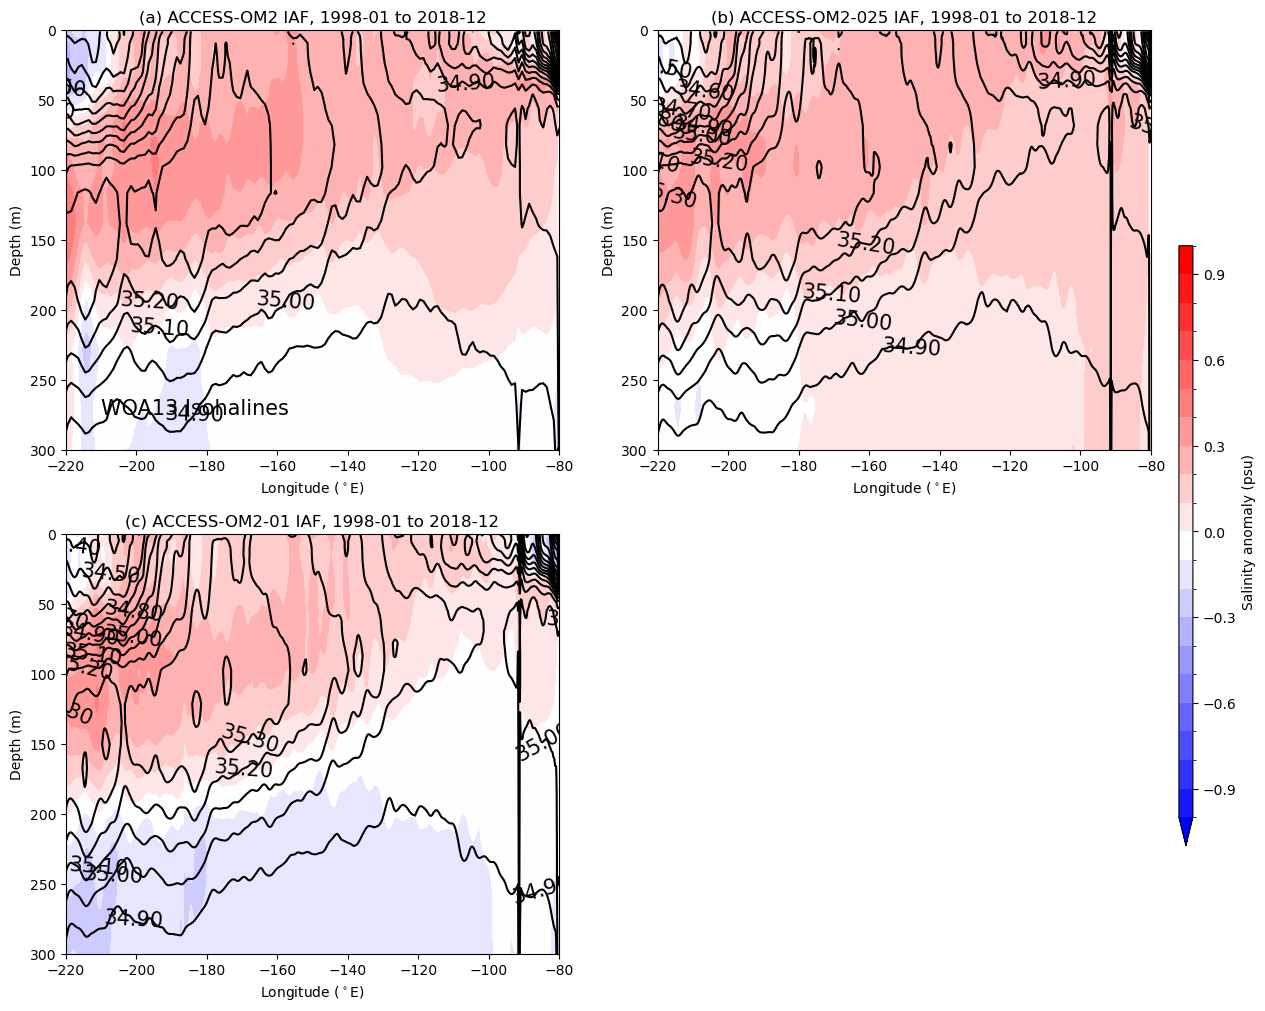

In [16]:
fig = plt.figure(figsize=(14, 12))
ekeys = ['1degIAF', '025degIAF', '01degIAF']
plot_eqsalt(ekeys)